Import

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json

Utilities

In [15]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """
    plt.figure(figsize=(10,6))

    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if legend:
        plt.legend(legend)

    plt.title(title)

    plt.grid(True)

    plt.show()

Preview Dataset

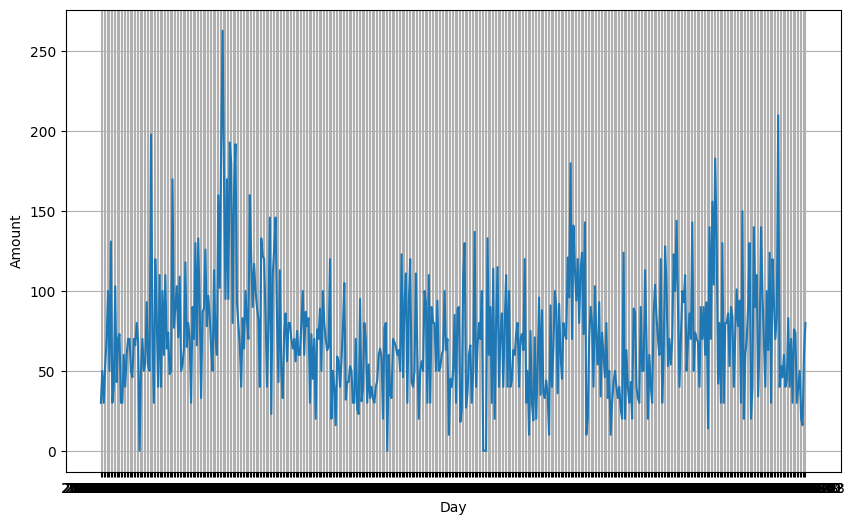

In [16]:
obat_id = '130'
file_name = './obat/'+ obat_id +'.json'
model_name = obat_id +".h5"

time_step = []
sales = []

with open(file_name) as jsonf:
    json_loads = json.loads(jsonf.read())
    for row in json_loads['data'].items():
        time_step.append(row[0])
        sales.append(float(row[1]))

time = np.array(time_step)
series = np.array(sales)

plot_series(time, series, xlabel='Day', ylabel='Amount')

Split the Dataset

In [17]:
split_time = 450

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

Prepare Features and Labels

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1],window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [19]:
window_size = 8
batch_size = 8
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Build Model

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                          strides=1,
                          activation='relu',
                          padding='causal',
                          input_shape=[window_size,1]),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 128)            768       
                                                                 
 lstm (LSTM)                 (None, 8, 128)            131584    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
 lambda (Lambda)             (None, 1)                 0

Tune the Learning Rate

In [21]:
init_weight = model.get_weights()

In [22]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(momentum=.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


56/56 [==============================] - 7s 20ms/step - loss: 73.4642 - lr: 1.0000e-08
Epoch 2/100
56/56 [==============================] - 1s 18ms/step - loss: 50.5246 - lr: 1.1220e-08
Epoch 3/100
56/56 [==============================] - 1s 18ms/step - loss: 38.4702 - lr: 1.2589e-08
Epoch 4/100
56/56 [==============================] - 1s 18ms/step - loss: 33.4130 - lr: 1.4125e-08
Epoch 5/100
56/56 [==============================] - 1s 18ms/step - loss: 31.1159 - lr: 1.5849e-08
Epoch 6/100
56/56 [==============================] - 1s 20ms/step - loss: 29.8051 - lr: 1.7783e-08
Epoch 7/100
56/56 [==============================] - 1s 18ms/step - loss: 29.0275 - lr: 1.9953e-08
Epoch 8/100
56/56 [==============================] - 1s 19ms/step - loss: 28.6742 - lr: 2.2387e-08
Epoch 9/100
56/56 [==============================] - 1s 20ms/step - loss: 28.5336 - lr: 2.5119e-08
Epoch 10/100
56/56 [==============================] - 1s 19ms/step - loss: 28.4239 - lr: 2.8184e-08
Epoch 11/100
56/56 [=

(1e-08, 0.001, 0.0, 100.0)

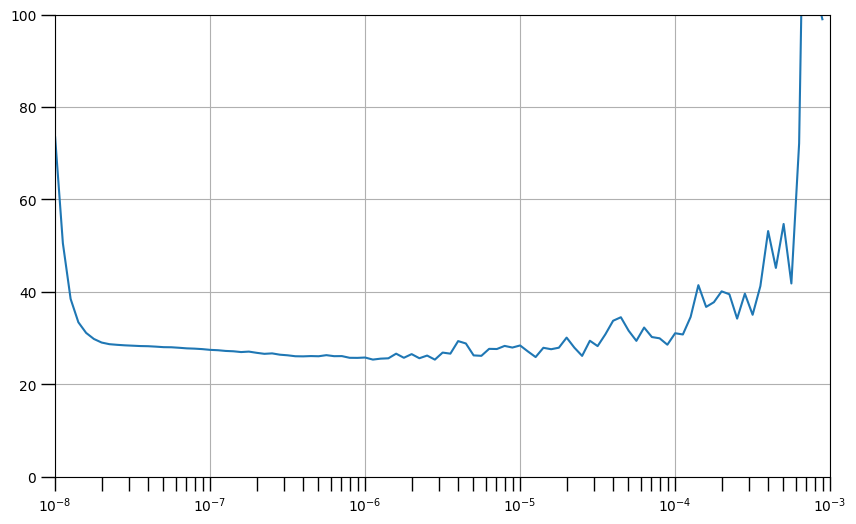

In [23]:
lrs = 1e-8 * (10**(np.arange(100)/20))

plt.figure(figsize=(10,6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-3, 0, 100])

Train the Model

In [24]:
tf.keras.backend.clear_session()

model.set_weights(init_weight)

In [25]:
learning_rate = 4e-7

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [26]:
history = model.fit(train_set, epochs=200)

Epoch 1/200


56/56 [==============================] - 9s 23ms/step - loss: 33.8836 - mae: 34.3798
Epoch 2/200
56/56 [==============================] - 2s 26ms/step - loss: 27.8325 - mae: 28.3281
Epoch 3/200
56/56 [==============================] - 1s 21ms/step - loss: 27.1635 - mae: 27.6576
Epoch 4/200
56/56 [==============================] - 1s 19ms/step - loss: 26.8491 - mae: 27.3449
Epoch 5/200
56/56 [==============================] - 1s 19ms/step - loss: 26.5066 - mae: 27.0014
Epoch 6/200
56/56 [==============================] - 1s 20ms/step - loss: 26.2126 - mae: 26.7071
Epoch 7/200
56/56 [==============================] - 1s 19ms/step - loss: 26.1112 - mae: 26.6059
Epoch 8/200
56/56 [==============================] - 1s 20ms/step - loss: 26.2844 - mae: 26.7823
Epoch 9/200
56/56 [==============================] - 1s 19ms/step - loss: 26.2222 - mae: 26.7168
Epoch 10/200
56/56 [==============================] - 1s 20ms/step - loss: 25.8647 - mae: 26.3620
Epoch 11/200
56/56 [=====================

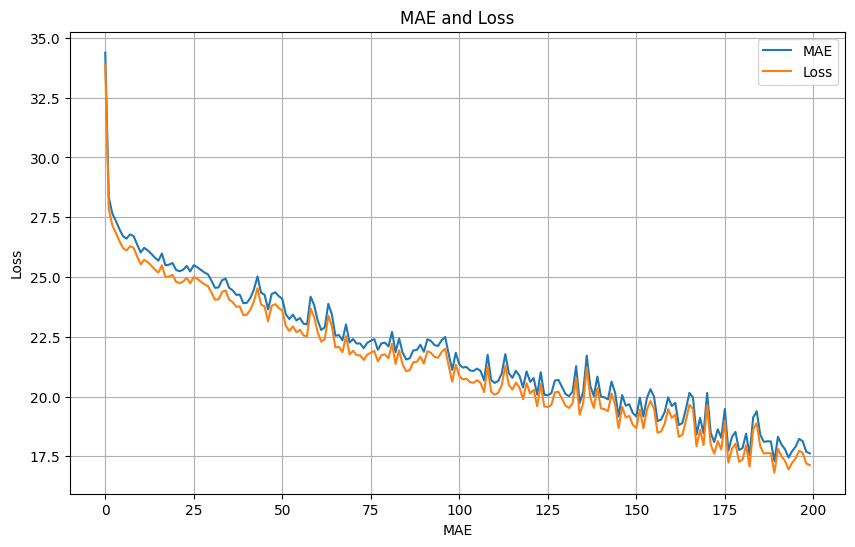

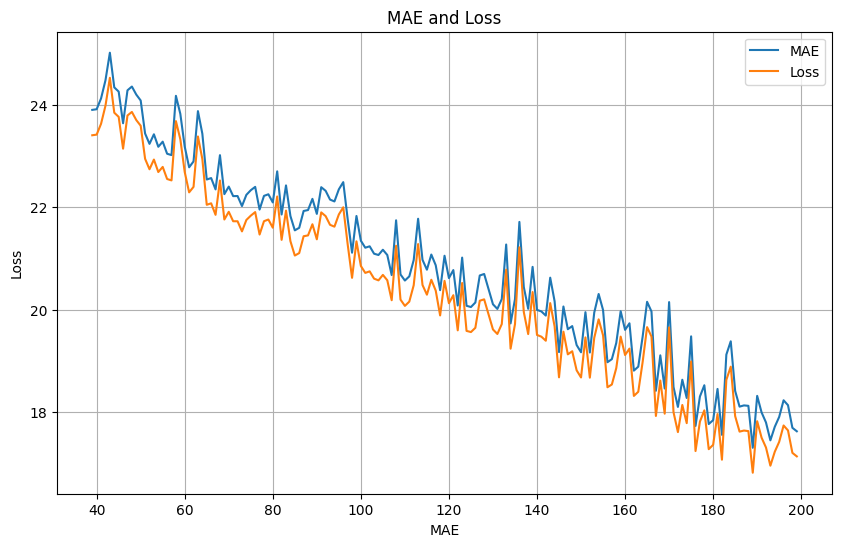

In [27]:
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
)

zoom_split = int(epochs[-1] * .2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
)

Model Prediction

In [28]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    dataset = tf.data.Dataset.from_tensor_slices(series)    
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model.predict(dataset)

    return forecast

6/6 [==============================] - 2s 12ms/step


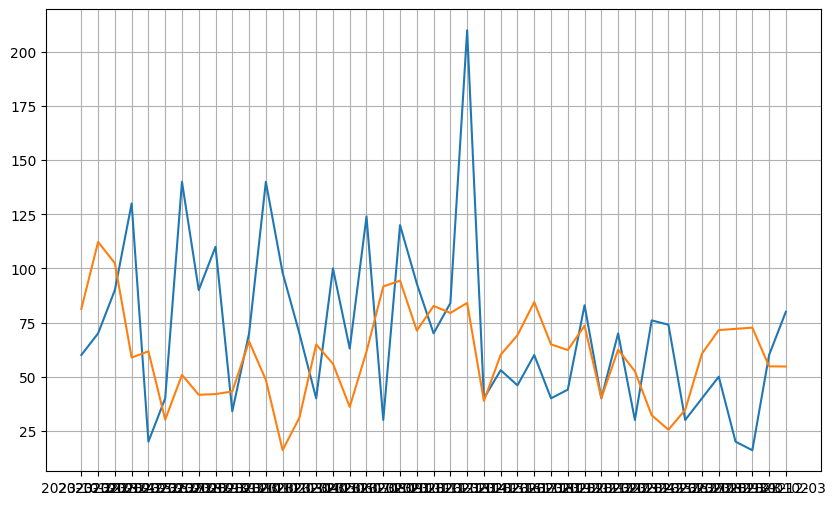

In [29]:
forecast_series = series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [30]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

33.887493


Optional

In [31]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=10)

Epoch 1/10


56/56 [==============================] - 8s 25ms/step - loss: 16.4020 - mae: 16.8936
Epoch 2/10
56/56 [==============================] - 1s 19ms/step - loss: 15.9457 - mae: 16.4332
Epoch 3/10
56/56 [==============================] - 1s 20ms/step - loss: 15.5422 - mae: 16.0295
Epoch 4/10
56/56 [==============================] - 2s 26ms/step - loss: 15.4887 - mae: 15.9761
Epoch 5/10
56/56 [==============================] - 1s 22ms/step - loss: 15.5791 - mae: 16.0689
Epoch 6/10
56/56 [==============================] - 1s 18ms/step - loss: 15.5682 - mae: 16.0515
Epoch 7/10
56/56 [==============================] - 1s 18ms/step - loss: 15.4790 - mae: 15.9607
Epoch 8/10
56/56 [==============================] - 1s 21ms/step - loss: 15.3751 - mae: 15.8650
Epoch 9/10
56/56 [==============================] - 1s 24ms/step - loss: 15.3020 - mae: 15.7926
Epoch 10/10
56/56 [==============================] - 1s 25ms/step - loss: 15.4648 - mae: 15.9485


In [32]:
def decayed_learning_rate(step):
    return initial_learning_rate * decay_rate ^ (step / decay_steps)

In [33]:
initial_learning_rate=1e-7

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=200)

Epoch 1/200


56/56 [==============================] - 8s 20ms/step - loss: 15.3977 - mae: 15.8816
Epoch 2/200
56/56 [==============================] - 1s 19ms/step - loss: 15.2006 - mae: 15.6852
Epoch 3/200
56/56 [==============================] - 1s 19ms/step - loss: 15.3832 - mae: 15.8729
Epoch 4/200
56/56 [==============================] - 1s 20ms/step - loss: 15.1470 - mae: 15.6300
Epoch 5/200
56/56 [==============================] - 1s 19ms/step - loss: 15.2940 - mae: 15.7801
Epoch 6/200
56/56 [==============================] - 1s 18ms/step - loss: 15.0913 - mae: 15.5747
Epoch 7/200
56/56 [==============================] - 1s 17ms/step - loss: 15.1323 - mae: 15.6179
Epoch 8/200
56/56 [==============================] - 1s 24ms/step - loss: 15.3107 - mae: 15.8005
Epoch 9/200
56/56 [==============================] - 1s 18ms/step - loss: 15.1425 - mae: 15.6275
Epoch 10/200
56/56 [==============================] - 1s 20ms/step - loss: 15.0607 - mae: 15.5454
Epoch 11/200
56/56 [=====================

6/6 [==============================] - 2s 14ms/step


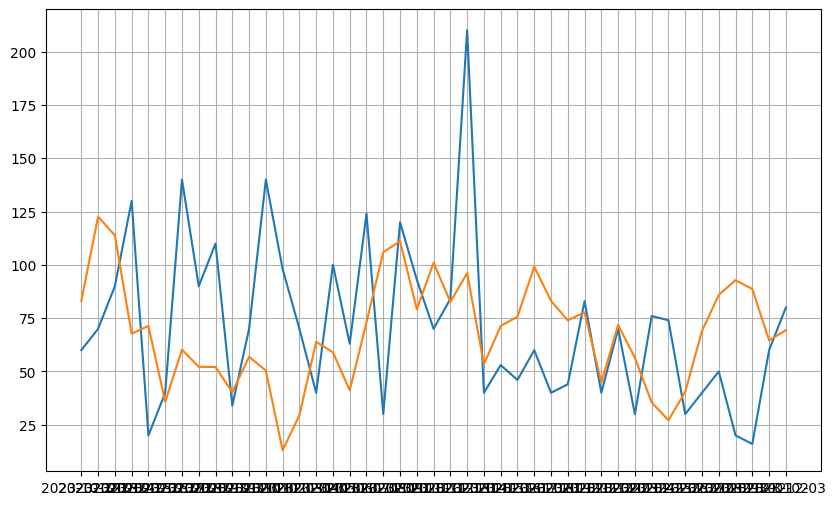

In [34]:
forecast_series = series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [35]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

35.938015

In [36]:
results[-1]

69.33941

In [37]:
path_dir = os.path.join(os.getcwd(), "model")
if not os.path.exists(path_dir):
    os.makedirs(path_dir)
model.save(os.path.join(path_dir, model_name))

c:\Users\KUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
